# Dataset

  This dataset is based on "Bank Marketing" UCI dataset (please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).
   The data is enriched by the addition of five new social and economic features/attributes (national wide indicators from a ~10M population country), published by the Banco de Portugal and publicly available at: https://www.bportugal.pt/estatisticasweb.
   This dataset is almost identical to the one used in [Moro et al., 2014] (it does not include all attributes due to privacy concerns).
   Using the rminer package and R tool (http://cran.r-project.org/web/packages/rminer/), we found that the addition of the five new social and economic attributes (made available here) lead to substantial improvement in the prediction of a success, even when the duration of the call is not included.

## Input variables:
### Bank client data:
- age (numeric)
- job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
- marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
- education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
- default: has credit in default? (categorical: "no","yes","unknown")
- housing: has housing loan? (categorical: "no","yes","unknown")
- loan: has personal loan? (categorical: "no","yes","unknown")
### related with the last contact of the current campaign:
- contact: contact communication type (categorical: "cellular","telephone")
- month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
- day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
- duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
### other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
### social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)     
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

##Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: "yes","no")

Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label.

# EDA

In [ ]:
impaort warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.graphics.mosaicplot import mosaic

import missingno as msno
!pip install robustats
import robustats

from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, \
                                    RepeatedStratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

!pip install umap-learn
import umap.umap_ as umap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Let's import the dataset and see its overall structure

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Myoth13/datasets/main/bank-additional-full.csv', delimiter=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

From the description file we can conclude that we have to drop `duration` column (this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.)

In [ ]:
#df.drop(labels=['duration'], axis=1, inplace=True)

Checking for useless data and constans

In [ ]:
(df.nuniq
ue()/len(df)).sort_values(ascending=False)

duration          0.037487
euribor3m         0.007672
age               0.001894
campaign          0.001020
pdays             0.000656
cons.conf.idx     0.000631
cons.price.idx    0.000631
job               0.000291
nr.employed       0.000267
month             0.000243
emp.var.rate      0.000243
previous          0.000194
education         0.000194
day_of_week       0.000121
marital           0.000097
default           0.000073
poutcome          0.000073
loan              0.000073
housing           0.000073
contact           0.000049
y                 0.000049
dtype: float64

We can see that there is no values close to 1 that means we do not have useless fields.

In [ ]:
df.var().sort_values(ascending=True)[0:5]

previous          0.244927
cons.price.idx    0.335056
emp.var.rate      2.467915
euribor3m         3.008308
campaign          7.672975
dtype: float64

We can see here that we don't have zero variance fields which means we don't have constans

## Missing data

There are several missing values in some categorical attributes, all coded with the "unknown" label. Let's replace them with NaN to see the structure of missingness.

In [ ]:
df.replace('unknown', np.nan, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

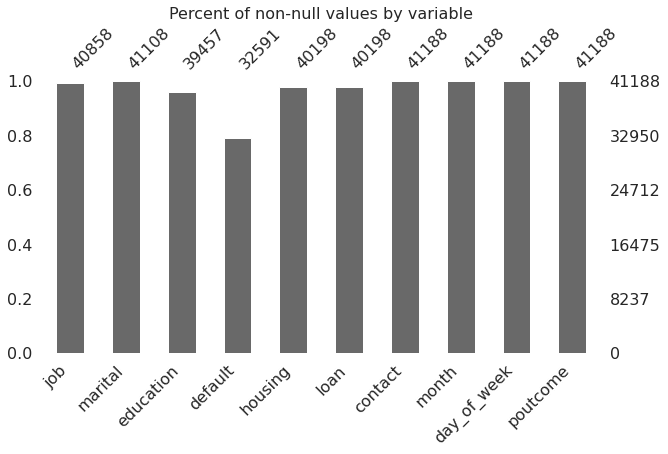

In [ ]:
cat_cols = df.select_dtypes(object).columns.tolist()
cat_cols.remove('y')

msno.bar(df[cat_cols], figsize=(10, 5))
plt.title('Percent of non-null values by variable', fontsize=16)
plt.show()

we can see here that columns `job`, `marital`, `education`, `housing` and `loan` have small amount of data missing. `default` has significantly more. Let's see the pattern.

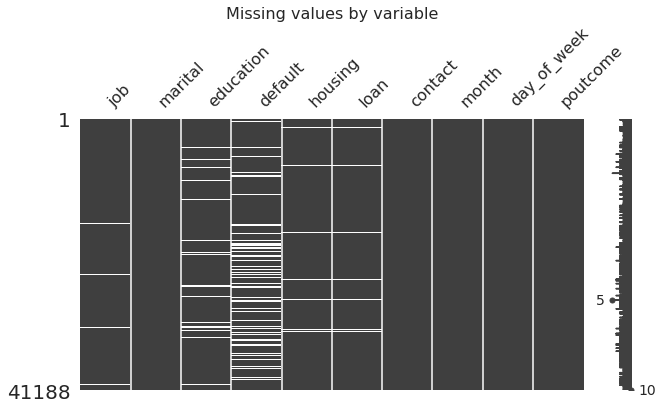

In [ ]:
df.sort_values('y', inplace=True)
msno.matrix(df[cat_cols], figsize=(10, 5))
plt.title('Missing values by variable', fontsize=16)
plt.show()

We can see here, that `housing` and `loan` data have the same pattern. I will impute all NaNs with the mode for the same education and job group except for `default` where I will replace back to 'unknown' as a third category level because there is too much missing data.

In [ ]:
#df['education'] = df.groupby(['job'], sort=False)['education'].apply(lambda x: x.fillna(x.mode()[0]))
#df['job'] = df.groupby(['education'], sort=False)['job'].apply(lambda x: x.fillna(x.mode()[0]))
#df['housing'] = df.groupby(['education', 'job'], sort=False)['housing'].apply(lambda x: x.fillna(x.mode()[0]))
#df['loan'] = df.groupby(['education', 'job'], sort=False)['loan'].apply(lambda x: x.fillna(x.mode()[0]))
df.default.replace(np.nan, 'unknown', inplace=True)
#msno.matrix(df[cat_cols], figsize=(10, 5))
#plt.title('Missing values by variable', fontsize=16)
#plt.show()

In [ ]:
#df.dropna(subset=['job', 'marital', 'housing', 'loan'], inplace=True)

## Data uniqueness

Let's check for duplicates

In [ ]:
df.duplicated().sum()

12

we can see here that we have quite a lot of duplicated records. Let's drop them.

In [ ]:
df.drop_duplicates(inplace=True)

## Data type constrains
As we can see below we are left with the fair amount of the data. Let's convert object type to category type to enchance memory utilization

Note: after watching the lecture I decided next time to incorporate this step into pipeline with label encoder, but I will leave it here for now.

In [ ]:
df[cat_cols] = df[cat_cols].astype('category')
df['y'] = df['y'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 30097
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41176 non-null  int64   
 1   job             40846 non-null  category
 2   marital         41096 non-null  category
 3   education       39446 non-null  category
 4   default         41176 non-null  category
 5   housing         40186 non-null  category
 6   loan            40186 non-null  category
 7   contact         41176 non-null  category
 8   month           41176 non-null  category
 9   day_of_week     41176 non-null  category
 10  duration        41176 non-null  int64   
 11  campaign        41176 non-null  int64   
 12  pdays           41176 non-null  int64   
 13  previous        41176 non-null  int64   
 14  poutcome        41176 non-null  category
 15  emp.var.rate    41176 non-null  float64 
 16  cons.price.idx  41176 non-null  float64 
 17  cons.conf.id

We can see that the data takes now significantly less memory which could be very beneficial if we would have a huge dataset.

## Categorical variables

Let's now see some descriptive statistics of categorical data.



In [ ]:
df[cat_cols].describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,40846,41096,39446,41176,40186,40186,41176,41176,41176,41176
unique,11,3,7,3,2,2,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10419,24921,12164,32577,21571,33938,26135,13767,8618,35551


Looks fine, let's check level counts to be sure

In [ ]:
for col in cat_cols:
  print(col+":\n")
  print(df[col].value_counts(normalize=True))
  print('\n')



job:

admin.           0.255080
blue-collar      0.226534
technician       0.164986
services         0.097121
management       0.071586
retired          0.042060
entrepreneur     0.035646
self-employed    0.034789
housemaid        0.025951
unemployed       0.024825
student          0.021422
Name: job, dtype: float64


marital:

married     0.606409
single      0.281390
divorced    0.112201
Name: marital, dtype: float64


education:

university.degree      0.308371
high.school            0.241140
basic.9y               0.153247
professional.course    0.132840
basic.4y               0.105866
basic.6y               0.058079
illiterate             0.000456
Name: education, dtype: float64


default:

no         0.791165
unknown    0.208762
yes        0.000073
Name: default, dtype: float64


housing:

yes    0.536779
no     0.463221
Name: housing, dtype: float64


loan:

no     0.844523
yes    0.155477
Name: loan, dtype: float64


contact:

cellular     0.634714
telephone    0.365286
Name: c

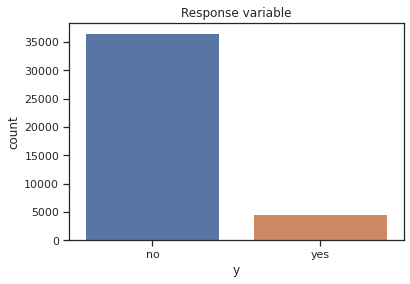

In [ ]:
sns.countplot(data=df, x='y')
plt.title('Response variable')
plt.show()

All levels look fine. But some variables (`default`, `poutcome`) contain very little information. Also looking at the response variable `y` we can see that the dataset is imbalanced (I will try SMOTE method later). Also we can see that conversion rate is 11% which is quite good.

Let's explore categorical features

### `job`

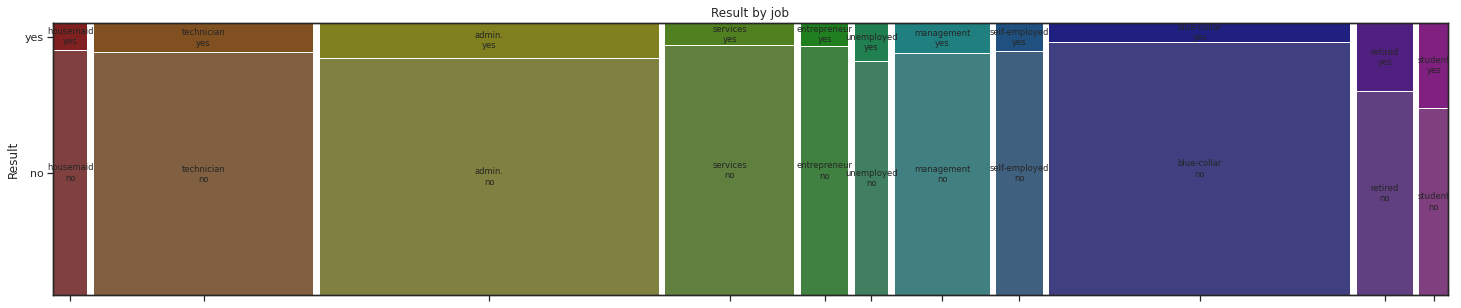

In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))
mosaic(df, ['job', 'y'], title='Result by job', ax=ax)
ax.set_xticklabels([])
ax.set_ylabel('Result')
plt.show()

We can see that the response variable differs significantly for different jobs which indicate that this feature is important

### `marital`

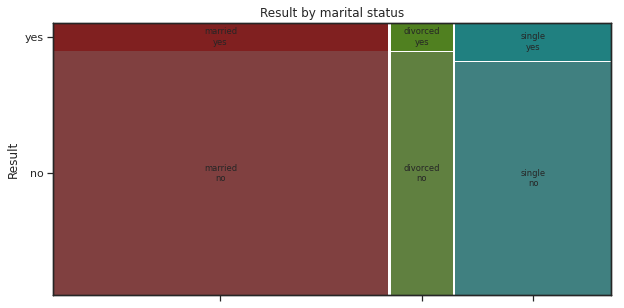

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
mosaic(df, ['marital', 'y'], title='Result by marital status', ax=ax)
ax.set_xticklabels([])
ax.set_ylabel('Result')
plt.show()

We can see here that 'single' level has more positive results.

### `education`

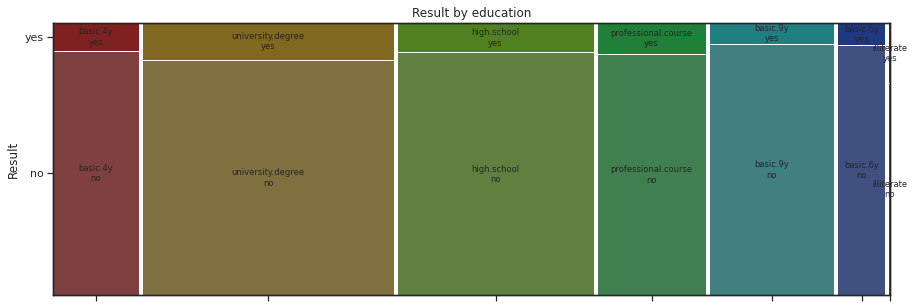

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
mosaic(df, ['education', 'y'], title='Result by education', ax=ax)
ax.set_xticklabels([])
ax.set_ylabel('Result')
plt.show()

We can see some difference between levels

### `loan` and `housing`

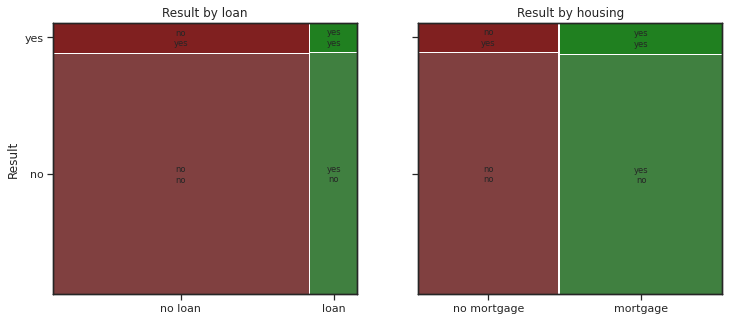

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2, sharey=True)

mosaic(df, ['loan', 'y'], title='Result by loan', ax=ax[0])
ax[0].set_xticklabels(['no loan','loan'])
ax[0].set_ylabel('Result')

mosaic(df, ['housing', 'y'], title='Result by housing', ax=ax[1])
ax[1].set_xticklabels(['no mortgage','mortgage'])
plt.show()


As we can see there is almost no difference between levels which indicates that these variables can be omitted

### `contact`

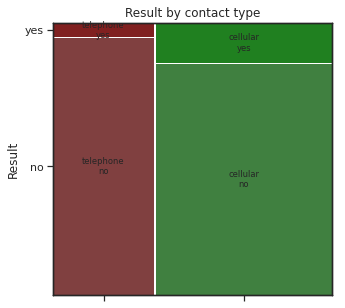

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
mosaic(df, ['contact', 'y'], title='Result by contact type', ax=ax)
ax.set_xticklabels([])
ax.set_ylabel('Result')
plt.show()


We can see that 'cellular' level has more positive results

### `month`

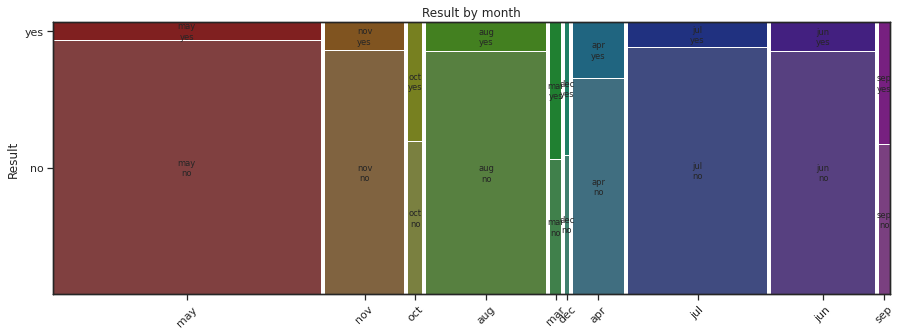

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
mosaic(df, ['month', 'y'], title='Result by month', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel('Result')
plt.show()

We can see some very interesting dynamic here - 'oct', 'mar', 'dec' and 'sep' has very little data points but much higher positive results proportion.

### `day_of_week`

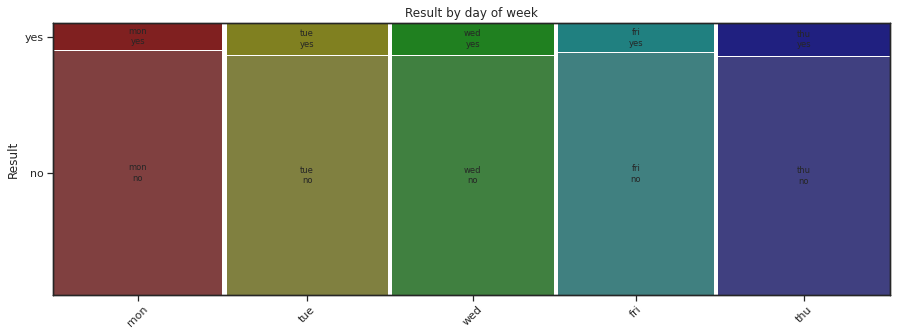

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
mosaic(df, ['day_of_week', 'y'], title='Result by day of week', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel('Result')
plt.show()

I don't see much difference between levels here

## Basic numeric variables

Let's see the description of the discrete numeric columns

In [ ]:
num_cols = ['age', 'campaign', 'pdays', 'previous']
display(df[num_cols].describe())

,age,campaign,pdays,previous
count,41176.00000,41176.000000,41176.000000,41176.000000
mean,40.02380,2.567879,962.464810,0.173013
std,10.42068,2.770318,186.937102,0.494964
min,17.00000,1.000000,0.000000,0.000000
25%,32.00000,1.000000,999.000000,0.000000
50%,38.00000,2.000000,999.000000,0.000000
75%,47.00000,3.000000,999.000000,0.000000
max,98.00000,56.000000,999.000000,7.000000


Basic stats look alright. Let's see plots

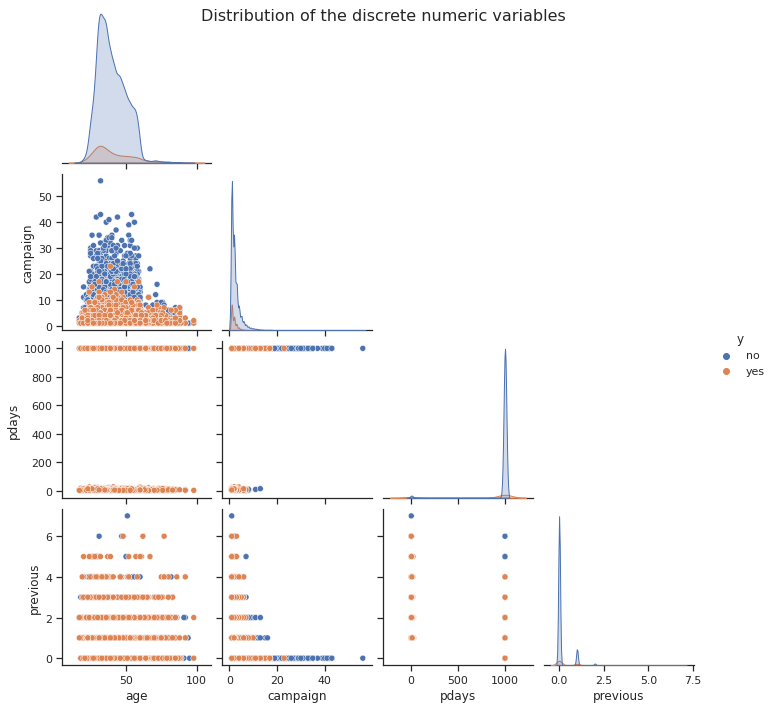

In [ ]:

tmp = df[num_cols].copy()
tmp['y'] = df['y']
sns.pairplot(tmp, corner=True, hue='y')
plt.suptitle('Distribution of the discrete numeric variables', fontsize=16)
plt.show()

From density plots we can see that `age` and `campaign` variables have outliers, `pdays` looks bimodal or even binary and `previous` variable has almost all data divided between 0 and 1. Also there is no visible correlation between this variable, but anyway let's look at correlation matrix.

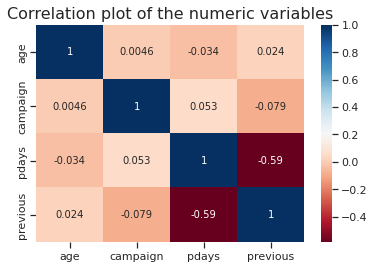

In [ ]:
sns.heatmap(df[num_cols].corr(), annot=True, cmap='RdBu')
plt.title('Correlation plot of the numeric variables', fontsize=16)
plt.show()

 We can see, that only `previous` and `pdays` have medium negative correlation. Let's look closer on each variable.

 ### `age`

In [ ]:
fig = px.histogram(
    data_frame=df,
    x='age',
    title='Age distribution',
    nbins=20,
    width = 800,
    height = 500
    )
fig.show()

The age distribution is skewed to the right with some outliers. The distribution is not normal so we can not use Z-score to detect outliers here. I could use the double MAD approach, but will try the adjusted boxplot method ( https://wis.kuleuven.be/stat/robust/papers/2008/adjboxplot-revision.pdf ) for detecting potential outliers.


In [ ]:
# we have to convert to float otherwise this function doesn't work
medcouple = robustats.medcouple(df[['age']].values.astype(np.float64))

print(medcouple)

0.2


when MC > 0, all observations outside the interval:

Q1 − 1.5 e−4MC IQR ; Q3 + 1.5 e3MC IQR]

will be marked as potential outlier.

In [ ]:
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)
iqr = q3 - q1
mn = q1 - 1.5 * np.exp(-4*medcouple)*iqr
mx = q3 + 1.5 * np.exp(3*medcouple)*iqr
print(f'Minimum limit: {mn:.2f}')
print(f'Maximum limit: {mx:.2f}')
display(df[ (mn > df['age']) | (df['age'] > mx) ])

Minimum limit: 21.89
Maximum limit: 88.00


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
24110,18,student,single,high.school,no,no,no,telephone,nov,thu,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.245,5195.8,no
27826,95,retired,divorced,basic.6y,no,no,no,cellular,mar,thu,...,1,999,0,nonexistent,-1.8,92.843,-50.0,1.650,5099.1,no
27815,88,retired,divorced,basic.4y,no,yes,yes,cellular,mar,wed,...,2,999,0,nonexistent,-1.8,92.843,-50.0,1.663,5099.1,no
27812,88,retired,divorced,basic.4y,no,yes,no,cellular,mar,wed,...,1,999,0,nonexistent,-1.8,92.843,-50.0,1.663,5099.1,no
27792,18,student,single,high.school,no,yes,yes,cellular,mar,tue,...,1,999,0,nonexistent,-1.8,92.843,-50.0,1.687,5099.1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30005,19,student,single,NaN,no,yes,yes,cellular,apr,tue,...,3,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,yes
37125,18,student,single,basic.9y,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,-2.9,92.201,-31.4,0.884,5076.2,yes
36982,21,unemployed,single,high.school,no,yes,no,cellular,jul,fri,...,1,999,0,nonexistent,-2.9,92.469,-33.6,1.059,5076.2,yes
37056,20,student,single,high.school,no,yes,no,cellular,jul,wed,...,1,999,0,nonexistent,-2.9,92.469,-33.6,1.029,5076.2,yes


We can see that according to the rule we have a lot of outliers. Let's see the distribution by response variable

In [ ]:
fig = px.box(
    data_frame=df,
    x='age',
    y='y',
    color='y',
    title='Distribution of the response variable by age')
fig.show()

The median age for the success result is slightly smaller, but the distribution is wider - there is more variance.  

### `campaign`

Let's see the overall distribution

In [ ]:
fig = px.histogram(
    data_frame=df,
    x='campaign',
    title='Campaing variable distribution')
fig.show()

The distribution is higly right skewed with outliers, let's calculate robust skeweness:

In [ ]:
medcouple = robustats.medcouple(df[['campaign']].values.astype(np.float64))

print(medcouple)

0.3333333333333333


the distribution is skewed I do not understand why the result is zero. In this case result will be classic 1.5*IQR.

In [ ]:
q1 = df['campaign'].quantile(0.25)
q3 = df['campaign'].quantile(0.75)
iqr = q3 - q1
mn = q1 - 1.5 * np.exp(-4*medcouple)*iqr
mx = q3 + 1.5 * np.exp(3*medcouple)*iqr
print(f'Minimum limit: {mn:.2f}')
print(f'Maximum limit: {mx:.2f}')
display(df[ (mn > df['campaign']) | (df['campaign'] > mx) ])

Minimum limit: 0.21
Maximum limit: 11.15


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
23929,33,admin.,single,university.degree,no,no,no,cellular,aug,fri,...,14,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
23728,35,management,married,university.degree,no,no,no,cellular,aug,thu,...,18,999,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,no
23740,50,admin.,married,basic.9y,no,no,no,cellular,aug,thu,...,14,999,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,no
23727,30,admin.,married,university.degree,no,yes,no,cellular,aug,thu,...,23,999,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,no
23713,35,technician,single,university.degree,no,no,no,cellular,aug,thu,...,17,999,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17216,39,admin.,married,university.degree,no,no,no,cellular,jul,fri,...,13,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,yes
17284,59,retired,married,high.school,no,yes,no,cellular,jul,fri,...,17,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,yes
21066,47,blue-collar,married,NaN,unknown,no,no,telephone,aug,thu,...,13,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,yes
16349,31,blue-collar,married,NaN,unknown,no,no,cellular,jul,tue,...,13,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,yes


This result shows a lot of potential outliers, but this is not very accurate.

For the modelling I would drop the far right tail alltogether or try to use log transformation:

In [ ]:
fig = px.histogram(
    data_frame=df,
    x='campaign',
    title='Log of the campaing variable',
    log_x=True
    )
fig.show()
#plt.title('Distribution of the log of campaign variable', fontsize=16)
#plt.show()

distribution of the response variable by `campaign`

In [ ]:
fig = px.box(
    data_frame=df,
    x='campaign',
    y='y',
    color='y',
    title='Distribution of the response variable by campaign')
fig.show()

We can see that the distribution differs significantly thus variable is important

### `pdays`

Let's see overall distribution

In [ ]:
fig = px.histogram(
    data_frame=df,
    x='pdays',
    title='Distribution of the pdays variable'
)
fig.show()

In [ ]:
display(df['pdays'].value_counts(bins=2))

(499.5, 999.0]    39661
(-1.0, 499.5]      1515
Name: pdays, dtype: int64

We can see that this field contains very little information - most of the points has value 999 (999 means client was not previously contacted). Variable `previous` is strongly correlated with the variable `pdays`.

## Econometric variables
Let's see econometric columns stat

In [ ]:
econ_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
display(df[econ_cols].describe())

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,1.570883,0.578839,4.627860,1.734437,72.251364
min,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,1.400000,94.767000,-26.900000,5.045000,5228.100000


Looks all right, but I'm not a huge specialist in economics. Let's see its distributions.

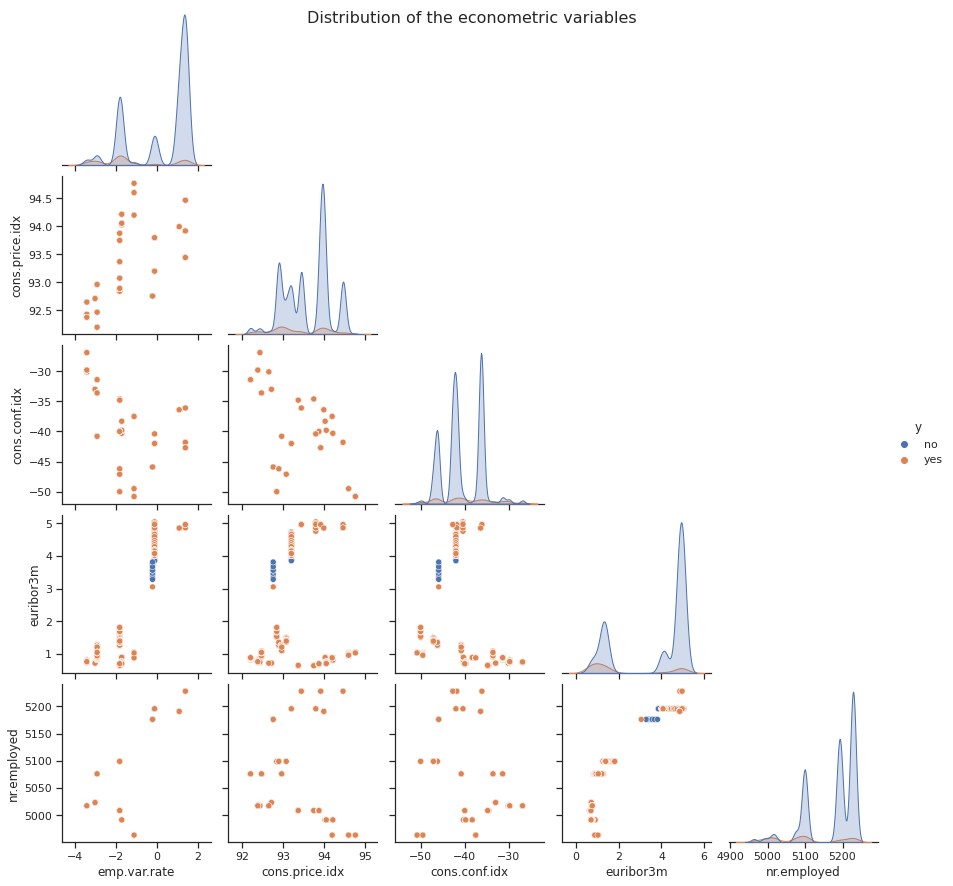

In [ ]:
tmp = df[econ_cols].copy()
tmp['y'] = df['y']
sns.pairplot(tmp, corner=True, hue='y')
plt.suptitle('Distribution of the econometric variables', fontsize=16)
plt.show()

It looks like that some variables are higly correlated. Let's see the correlation map

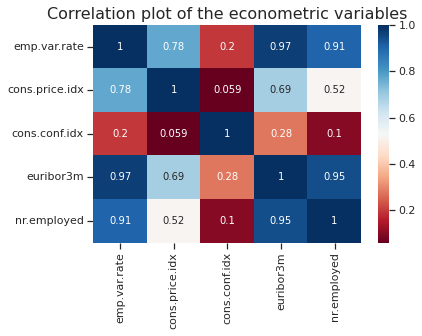

In [ ]:
sns.heatmap(df[econ_cols].corr(), annot=True, cmap='RdBu')
plt.title('Correlation plot of the econometric variables', fontsize=16)
plt.show()

The dimentionality reduction will be definately usefull here

# Multivariate outliers detection

As we have seen above - we have quite a large number of outliers according to the adjusted boxplot method above. So I would like to try out more sophisticated method

In [ ]:
clf = IsolationForest()
preds = clf.fit_predict(pd.get_dummies(df, drop_first=True))
outliers = df[preds==-1]
print(outliers.shape)

(3813, 21)


We can see that the model found more then 4000 outliers, which is quite a lot. Let's explore it

In [ ]:
display(outliers.head())

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
25293,41,technician,single,professional.course,unknown,yes,no,cellular,nov,tue,...,2,4,1,success,-0.1,93.2,-42.0,4.153,5195.8,no
25269,30,management,married,university.degree,no,no,yes,cellular,nov,tue,...,2,999,1,failure,-0.1,93.2,-42.0,4.153,5195.8,no
25274,34,services,married,basic.9y,no,no,no,cellular,nov,tue,...,2,4,1,success,-0.1,93.2,-42.0,4.153,5195.8,no
25276,37,management,married,university.degree,no,no,no,cellular,nov,tue,...,3,999,1,failure,-0.1,93.2,-42.0,4.153,5195.8,no
25336,34,management,married,university.degree,no,yes,yes,cellular,nov,tue,...,3,999,1,failure,-0.1,93.2,-42.0,4.153,5195.8,no


It's very hard to see, but I will try to omit them in modelling and see the performance.

# Dimentionality reduction

I will start with PCA to catch 95% of the variance and than proceed to manifold techniques to visualize in 2D space. I will use MinMaxScaler scaling as a scaling method.

From the description file we can conclude that we have to drop duration column (this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.)

In [ ]:
all_num_cols = df.select_dtypes('number').columns

y = df['y']
X = df.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


num_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('transform', QuantileTransformer(output_distribution='normal'))
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse=False)),
    ('imputer', KNNImputer()),

])

pipeline = ColumnTransformer(transformers=[
    ('cat', cat_pipeline, cat_cols),
    ('num', num_pipeline, all_num_cols),
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.fit_transform(X_test)
print(X_train.shape)
print(X_test.shape)

(30882, 63)
(10294, 63)


Now we have our data ready let's start with PCA

## PCA

In [ ]:
pca = PCA(n_components=0.95)
transformed = pca.fit_transform(X_train)
print(transformed)

[[ 7.28525527 -2.25741688 -3.06578591 ... -0.19931782  1.04286881
   0.04713909]
 [ 2.61547708 -3.00240249 -1.63892195 ... -0.18810575  0.41344968
  -0.31771481]
 [ 2.83664423  2.48768166 -1.81550259 ... -0.27253761  0.08827016
  -0.34580759]
 ...
 [-4.66133209 -4.14278942  0.5667146  ... -0.39348187  0.32142035
  -0.16466514]
 [ 1.38232478  3.4432641  -1.71684001 ... -0.27594379 -0.44438006
  -0.30299891]
 [ 4.41182584 -2.83812849  4.27655477 ...  0.05763413  0.51136612
  -0.27079397]]


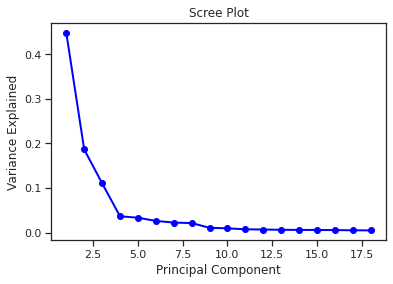

In [ ]:
PCA_values = np.arange(pca.n_components_) + 1
plt.plot(PCA_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

We can see how much components selected the algorythm:

In [ ]:
print(pca.n_components_)

18


We can see that the first few components contains the most variance explained. Now I will visualize first two components that contributes to this percent of explaned variance:

In [ ]:
print(pca.explained_variance_ratio_[0:2].sum())

0.6344474746412472


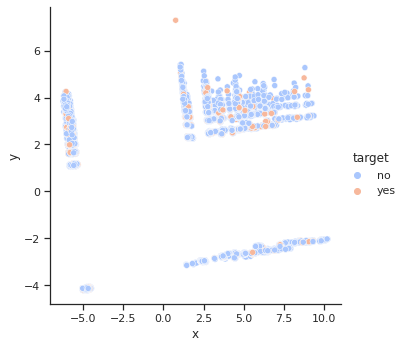

In [ ]:
plot_df = pd.DataFrame.from_records(data=transformed[:,:2], columns=['x', 'y'])
plot_df['target'] = y_train

sns.set(style='ticks')
sns.relplot(x='x', y='y', data=plot_df, hue='target', palette='coolwarm')
plt.show()

As we can see on the graph separation is not really visible. Let's try different methods

## SVD

In [ ]:
svd = TruncatedSVD(n_components=X_train.shape[1]-1)
transformed_svd = svd.fit_transform(X_train)

Let's visualise the result

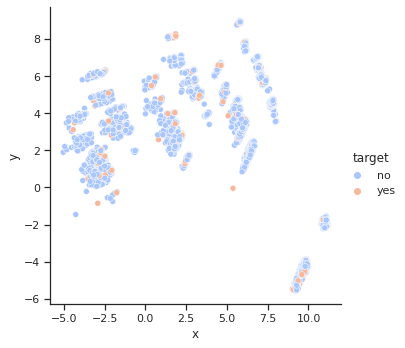

In [ ]:
plot_df = pd.DataFrame.from_records(data=transformed_svd[:,:2], columns=['x', 'y'])
plot_df['target'] = y_train

sns.set(style='ticks')
sns.relplot(x='x', y='y', data=plot_df, hue='target', palette='coolwarm')
plt.show()

There is an overlap as well. Let's select the number of components to capture 95% of explaned variance

In [ ]:
def select_n_components(var_ratios, goal_var: float) -> int:
  total_variance = 0.0
  n_components = 0

  for explained_variance in var_ratios:
    total_variance += explained_variance
    n_components += 1

    if total_variance >= goal_var:
        break

  return n_components

expected_number_of_components = select_n_components(svd.explained_variance_ratio_, 0.95)
print(expected_number_of_components)

19


As we can see here to capture 95% of the variance we need 19 components.

## t-SNE

I tried to run t-SNE on the original scaled dataframe but it took too long time and I used already treamed by PCA features.

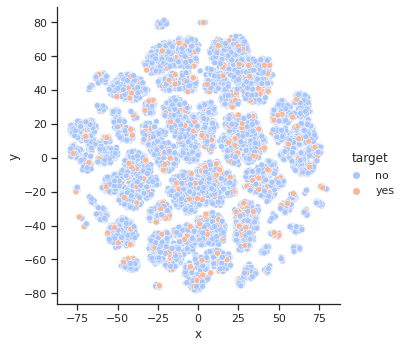

In [ ]:
tsne = TSNE()
transformed_tsne = tsne.fit_transform(transformed)

plot_df = pd.DataFrame.from_records(data=transformed_tsne[:,:2], columns=['x', 'y'])
plot_df['target'] = y_train

sns.set(style='ticks')
sns.relplot(x='x', y='y', data=plot_df, hue='target', palette='coolwarm')
plt.show()

Still no clear feature separation present. Let's try UMAP

## UMAP

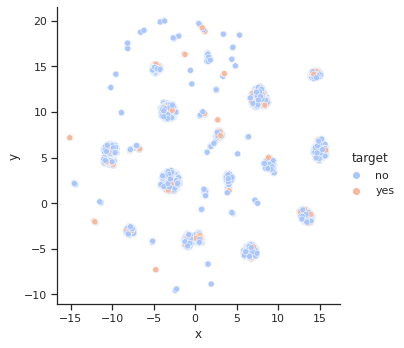

In [ ]:
um = umap.UMAP()
transformed_um = um.fit_transform(X_train)

plot_df = pd.DataFrame.from_records(data=transformed_um[:,:2], columns=['x', 'y'])
plot_df['target'] = y_train

sns.set(style='ticks')
sns.relplot(x='x', y='y', data=plot_df, hue='target', palette='coolwarm')
plt.show()


We can see that there is also no clear separation of target variable.

# Modeling

I made simple decisicon tree classifier to experiment. From the first run it has very low performance on positive class

In [ ]:
print(X_train.shape)
print(X_test.shape)
tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)

scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))
y_pred = tree.predict(X_test)
print(classification_report(y_test,y_pred))

(30882, 63)
(10294, 63)
Mean ROC AUC: nan
              precision    recall  f1-score   support

          no       0.94      0.92      0.93      9134
         yes       0.48      0.54      0.51      1160

    accuracy                           0.88     10294
   macro avg       0.71      0.73      0.72     10294
weighted avg       0.89      0.88      0.88     10294



Let's try out SMOTE

In [ ]:
y = df['y']
X = df.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

over = SMOTE(sampling_strategy=0.3)
#under = RandomUnderSampler(sampling_strategy=1)

num_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('transform', QuantileTransformer(output_distribution='normal'))
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse=False)),
    ('imputer', KNNImputer()),
    ('over', over),


])

preprocessor = ColumnTransformer(
    transformers=[
      ('cat', cat_pipeline, cat_cols),
      ('num', num_pipeline, all_num_cols),
])

pipeline_SMOTE = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier())]
)

# evaluate pipeline
#scores = cross_val_score(pipeline_SMOTE, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
#print('Mean ROC AUC: %.3f' % np.mean(scores))
pipeline_SMOTE.fit(X_train, y_train)
y_pred = pipeline_SMOTE.predict(X_test)
print(classification_report(y_test,y_pred))

TypeError: ignored

Still very low, would love to try different models, but I will leave it for now as it is, because I'm running out of time